In [1]:
import math
import random
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Initial conditions
def init():
    mc = 0
    rt_clock = 3
    non_rt_clock = 5
    n_rt = 0
    n_non_rt = 0
    server_status = 2
    scl = 4
#     print(f"{mc}\t{rt_clock}\t{non_rt_clock}\t{n_rt}\t{n_non_rt}\t{scl}\t{server_status}")
    return mc, rt_clock, non_rt_clock, n_rt, n_non_rt, scl, server_status


def sample(time):
    return -1 * time * math.log(random.uniform(0, 1))


def simulation_with_randomness(iat_rt, iat_non_rt, st_rt, st_non_rt, m, b):
    mc, rt_clock, non_rt_clock, n_rt, n_non_rt, scl, server_status = init()
    non_rt_queue = []
    time_rt = []
    start_non_rt = []
    count = 0
    while len(time_rt) < m*b or len(start_non_rt) < m*b:
        if rt_clock <= scl:
            mc = rt_clock
            n_rt += 1
            if scl - rt_clock != 0:
                non_rt_queue = [(scl - rt_clock, 0)] + non_rt_queue
                start_non_rt.append((1, scl - rt_clock, mc))
                n_non_rt += 1
            if n_rt == 1:
                prev_rt_clock = rt_clock
                rt_clock = round(rt_clock + sample(iat_rt), 2)
                server_status = 1
                simulated_time = sample(st_rt)
                scl = round(mc + simulated_time, 2)
                n_rt -= 1
                time_rt.append((rt_clock, simulated_time))
        elif non_rt_clock < scl:
            mc = non_rt_clock
            r_st_non_rt = sample(st_non_rt)
            non_rt_queue.append((r_st_non_rt, mc))
            start_non_rt.append((0, r_st_non_rt, mc))
            n_non_rt += 1
            non_rt_clock = round(non_rt_clock + sample(iat_non_rt), 2)
            server_status = 2
            scl = round(mc + r_st_non_rt, 2)
        else:
            if mc == non_rt_clock:
                non_rt_clock = round(non_rt_clock + sample(iat_non_rt), 2)
                n_non_rt += 1
                sim_non_rt = sample(st_non_rt)
                non_rt_queue.append((sim_non_rt, mc))
                start_non_rt.append((0,sim_non_rt, mc))
            elif non_rt_queue:
                count += 1
                n_non_rt -= 1
                server_status = 2
                scl = round(mc + non_rt_queue[0][0], 2)
                if non_rt_queue[0][1] == 0:
                    temp = start_non_rt[0]
                    start_non_rt.pop(0)
                    start_non_rt.append((0, temp[1] + mc - temp[2] , -1))
                non_rt_queue.pop(0)
                
                
#         print(f"{mc}\t{rt_clock}\t{non_rt_clock}\t{n_rt}\t{n_non_rt}\t{scl}\t{server_status}")

        if n_non_rt == 0 and n_rt == 0:
            server_status = 0
            scl = min(rt_clock, non_rt_clock)

        mc = scl
    return time_rt, start_non_rt

if __name__ == '__main__':
    iat_rt = int(input("Mean inter-arrival time of RT messages"))
#     Excluded iat_non_rt as I am automating the graph generation for each iteration
    st_rt = int(input("Mean service time of an RT message"))
    st_non_rt = int(input("Mean service time of a nonRT message"))
    m = int(input("Number of batches, m"))
    b = int(input("Batch size, b"))
    rt = []
    non_rt = []
    for i in range(10,40,5):
        x, y = simulation_with_randomness(iat_rt, i, st_rt, st_non_rt, m, b)
        rt.append(list(zip(*x))[1][1000:])
        non_rt.append(list(zip(*y))[1][1000:])

Mean inter-arrival time of RT messages7
Mean service time of an RT message2
Mean service time of a nonRT message4
Number of batches, m51
Batch size, b1000


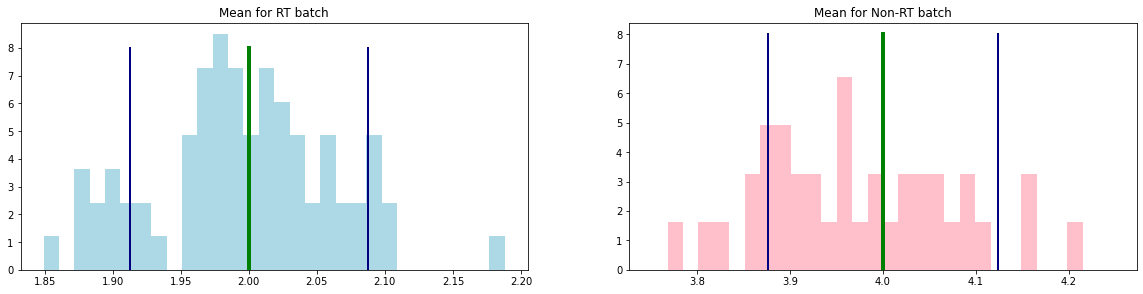

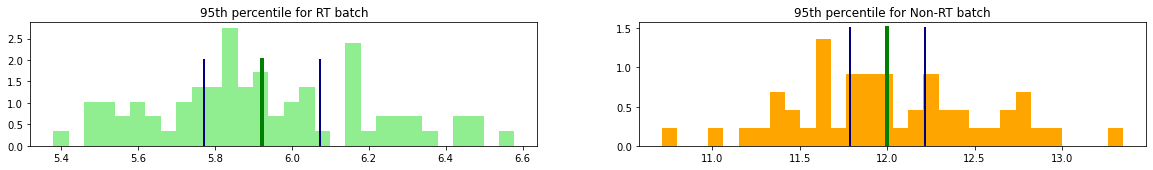

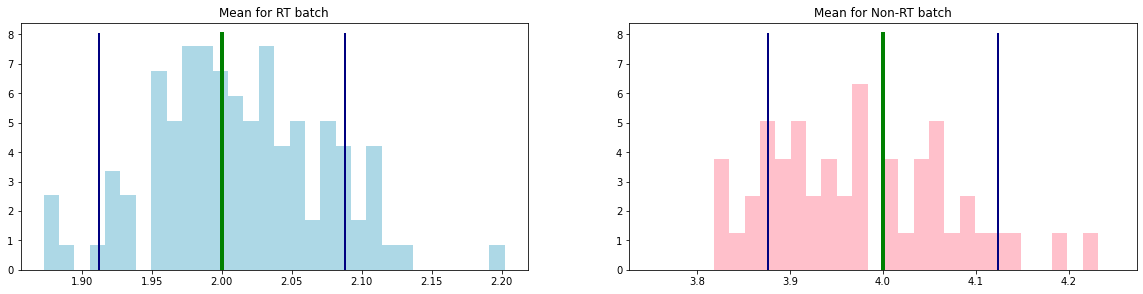

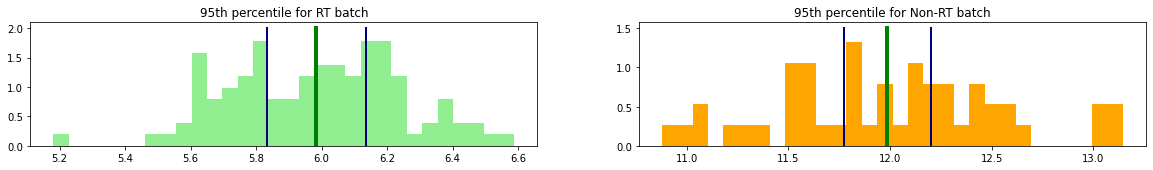

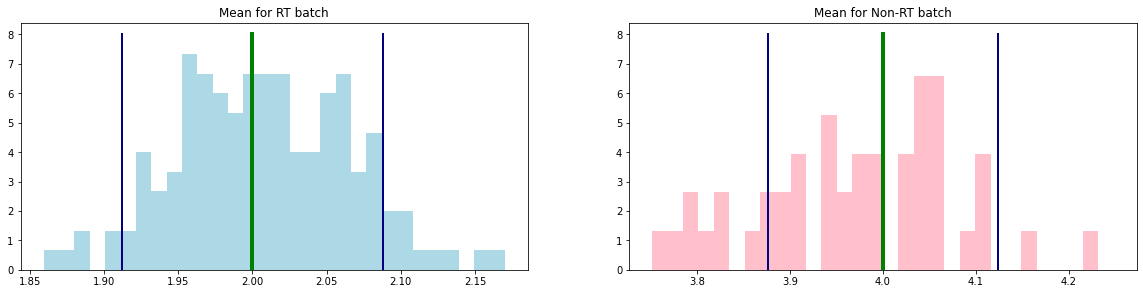

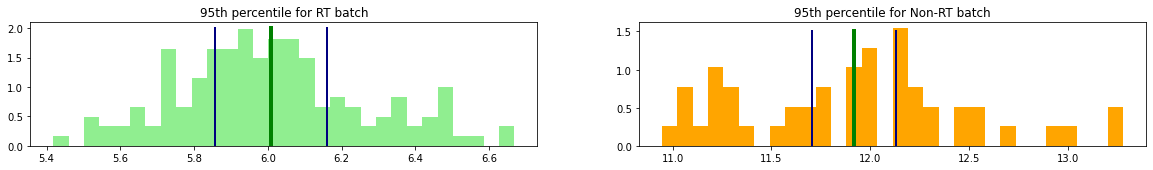

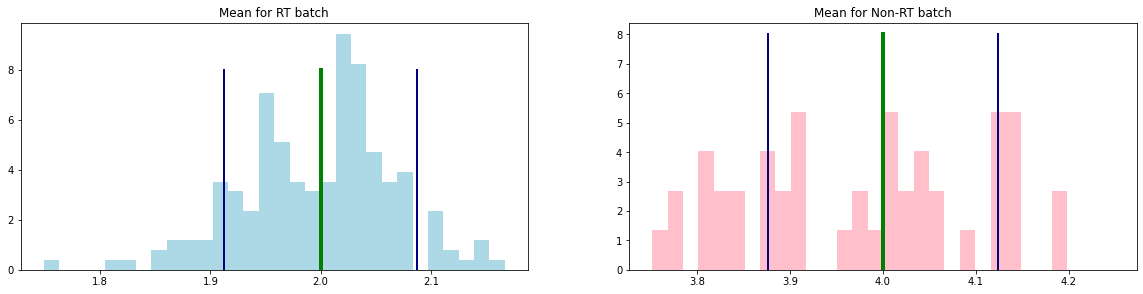

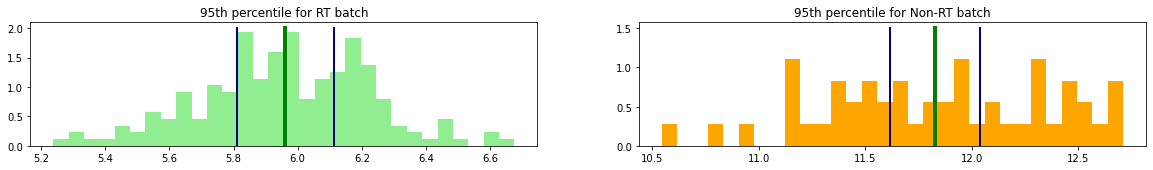

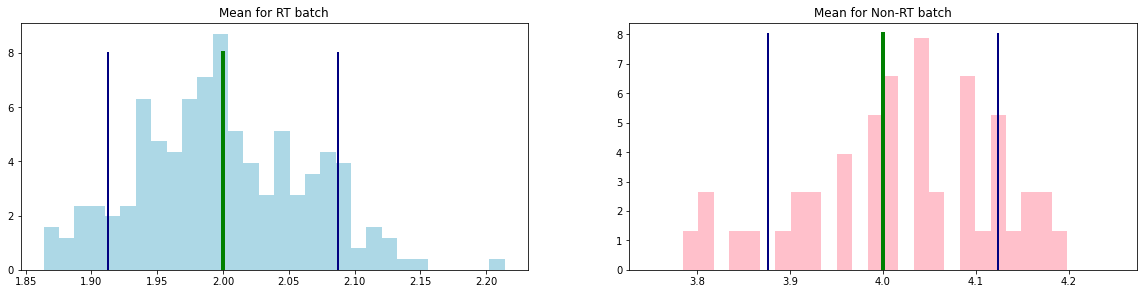

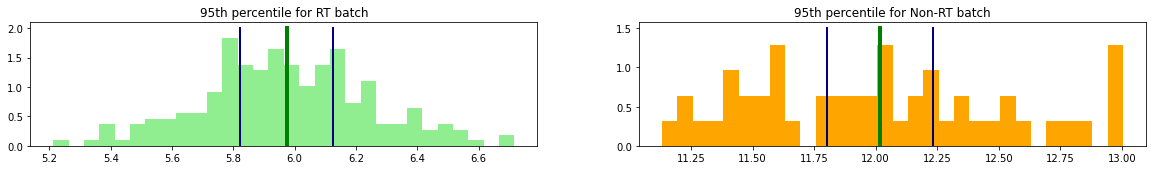

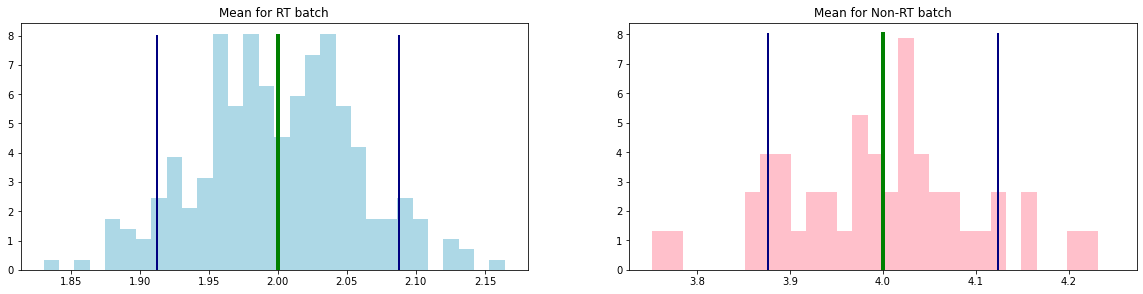

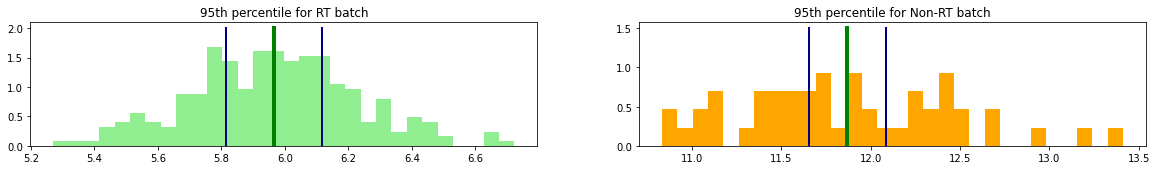

In [4]:
# Graph generation

for real, non_real in zip(rt, non_rt):
    real_batches = [real[i:i + b] for i in range(0, len(real), b)]
    non_real_batches = [non_real[i:i + b] for i in range(0, len(non_real), b)]
    
    r_b_mean = []
    non_r_b_mean = []
    r_b_95 = []
    non_r_b_95 = []
    for r_batch in real_batches:
        r_b_mean.append(sum(r_batch)/len(r_batch))
        r_b_95.append(np.percentile(r_batch, 95))
    for non_r_batch in non_real_batches:
        non_r_b_mean.append(sum(non_r_batch)/len(non_r_batch))
        non_r_b_95.append(np.percentile(non_r_batch, 95))
    
    mu = st_rt
    sigma = np.sqrt(mu)
    interval = 1.96*sigma/np.sqrt(b)

    plt.figure(figsize=(20,10))
    plt.subplot(221)
    plt.title("Mean for RT batch")
    plt.hist(r_b_mean, 30, density=True, color="lightblue")
    plt.plot([mu,mu],[0, 8], 'k-', lw=4, color='green')
    plt.plot([mu-interval,mu-interval],[0, 8], 'k-', lw=2, color='navy')
    plt.plot([mu+interval,mu+interval],[0, 8], 'k-', lw=2, color='navy')
    
    mu = st_non_rt
    sigma = np.sqrt(mu)
    interval = 1.96*sigma/np.sqrt(b)
    plt.subplot(222)
    plt.title("Mean for Non-RT batch")

    plt.hist(non_r_b_mean, 30, range=[mu-2*interval, mu+2*interval], density=True, color='pink')
    plt.plot([mu,mu],[0, 8], 'k-', lw=4, color='green')
    plt.plot([mu-interval,mu-interval],[0, 8], 'k-', lw=2, color='navy')
    plt.plot([mu+interval,mu+interval],[0, 8], 'k-', lw=2, color='navy')
    
    mu = sum(r_b_95)/len(r_b_95)
    sigma = np.sqrt(mu)
    interval = 1.96*sigma/np.sqrt(b)

    plt.figure(figsize=(20,10))
    plt.subplot(221)
    plt.title("95th percentile for RT batch")

    plt.hist(r_b_95, 30, density=True, color='lightgreen')
    plt.plot([mu,mu],[0, 2], 'k-', lw=4, color='green')
    plt.plot([mu-interval,mu-interval],[0, 2], 'k-', lw=2, color='navy')
    plt.plot([mu+interval,mu+interval],[0, 2], 'k-', lw=2, color='navy')
    
    mu = sum(non_r_b_95)/len(non_r_b_95)
    sigma = np.sqrt(mu)
    interval = 1.96*sigma/np.sqrt(b)
    plt.subplot(222)
    plt.title("95th percentile for Non-RT batch")
    plt.hist(non_r_b_95, 30, density=True, color='orange')
    plt.plot([mu,mu],[0, 1.5], 'k-', lw=4, color='green')
    plt.plot([mu-interval,mu-interval],[0, 1.5], 'k-', lw=2, color='navy')
    plt.plot([mu+interval,mu+interval],[0, 1.5], 'k-', lw=2, color='navy')
    plt.show()
    plt.close()

In [3]:
samplesize

NameError: name 'samplesize' is not defined